## *Imports*

In [1]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions

from IPython.display import display as ipydisplay, Image, clear_output, HTML # for interacting with the notebook better

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

import keras # high level api to tensorflow (or theano, CNTK, etc.) and useful image preprocessing
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
print('Keras image data format: {}'.format(K.image_data_format()))

OpenCV Version: 4.2.0


Bad value in file '/Users/arynas/.matplotlib/matplotlibrc', line 1 ('backend: TkAggy'): Key backend: 'tkaggy' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


Keras image data format: channels_last


## *Constants*

In [2]:
IMAGES_FOLDER = os.path.join('images') # images for visuals

MODEL_PATH = os.path.join('model')
MODEL_FILE = os.path.join(MODEL_PATH, 'hand_model_gray.hdf5') # path to model weights and architechture file
MODEL_HISTORY = os.path.join(MODEL_PATH, 'model_history.txt') # path to model training history

In [3]:
def bgrtorgb(image):
    return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

#### Jupyter Notebook image display

In [4]:
def show_image(name):
    """
    Showing image files.
    """
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

In [5]:
def plot_image(image, figsize=(8,8), recolour=False):
    """
    Plotting image matricies.
    """
    if recolour: image = bgrtorgb(image)
    plt.figure(figsize=figsize)
    if image.shape[-1] == 3:
        plt.imshow(image)
    elif image.shape[-1] == 1 or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        raise Exception("Image has invalid shape.")

In [6]:
# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if tracker_type == 'BOOSTING':
        tracker = cv2.TrackerBoosting_create()
    if tracker_type == 'MIL':
        tracker = cv2.TrackerMIL_create()
    if tracker_type == 'KCF':
        tracker = cv2.TrackerKCF_create()
    if tracker_type == 'TLD':
        tracker = cv2.TrackerTLD_create()
    if tracker_type == 'MEDIANFLOW':
        tracker = cv2.TrackerMedianFlow_create()
    if tracker_type == 'GOTURN':
        tracker = cv2.TrackerGOTURN_create()
    
    return tracker

In [7]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'thumbsup',
    3: 'yo'
}

# CURR_POSE = 'five'
# DATA = 'training_data'

# # Helper function for applying a mask to an array
# def mask_array(array, imask):
#     if array.shape[:2] != imask.shape:
#         raise Exception("Shapes of input and imask are incompatible")
#     output = np.zeros_like(array, dtype=np.uint8)
#     for i, row in enumerate(imask):
#         output[i, row] = array[i, row]
#     return output


# # Begin capturing video
# video = cv2.VideoCapture(1)
# if not video.isOpened():
#     print("Could not open video")
#     sys.exit()


# # Read first frame
# ok, frame = video.read()
# if not ok:
#     print("Cannot read video")
#     sys.exit()
# # Use the first frame as an initial background frame
# bg = frame.copy()


# # Kernel for erosion and dilation of masks
# kernel = np.ones((3,3),np.uint8)


# # Tracking
# # Bounding box -> (TopRightX, TopRightY, Width, Height)
# bbox_initial = (60, 60, 170, 170)
# bbox = bbox_initial
# # Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
# tracking = -1


# # Text display positions
# positions = {
#     'hand_pose': (15, 40),
#     'fps': (15, 20)
# }


# # Image count for file name
# img_count = 0

# # Capture, process, display loop    
# while True:
#     # Read a new frame
#     ok, frame = video.read()
#     display = frame.copy()
#     if not ok:
#         break
        
        
#     # Start timer
#     timer = cv2.getTickCount()

    
#     # Processing
#     # First find the absolute difference between the two images
#     diff = cv2.absdiff(bg, frame)
#     mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
#     # Threshold the mask
#     th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
#     # Opening, closing and dilation
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
#     closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#     img_dilation = cv2.dilate(closing, kernel, iterations=2)
#     # Get mask indexes
#     imask = img_dilation > 0
#     # Get foreground from mask
#     foreground = mask_array(frame, imask)
#     foreground_display = foreground.copy()
    
    
#     # If tracking is active, update the tracker
#     if tracking != -1:
#         tracking, bbox = tracker.update(foreground)
#         tracking = int(tracking)
        
        
#     # Use numpy array indexing to crop the foreground frame
#     hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
#     # Draw bounding box
#     p1 = (int(bbox[0]), int(bbox[1]))
#     p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
#     cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
#     cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
#     # Calculate Frames per second (FPS)
#     fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
#     # Display FPS on frame
#     cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
#     cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
#     # Display result
#     cv2.imshow("display", display)
#     # Display diff
#     cv2.imshow("diff", diff)
#     # Display thresh
#     cv2.imshow("thresh", thresh)
#     # Display mask
#     cv2.imshow("img_dilation", img_dilation)
#     try:
#         # Display hand_crop
#         cv2.imshow("hand_crop", hand_crop)
#     except:
#         pass
#     # Display foreground_display
#     cv2.imshow("foreground_display", foreground_display)
    
    
#     k = cv2.waitKey(1) & 0xff
    
#     if k == 27: break # ESC pressed
#     elif k == 114 or k == 112: 
#         # r pressed
#         bg = frame.copy()
#         bbox = bbox_initial
#         tracking = -1
#     elif k == 116:
#         # t pressed
#         # Initialize tracker with first frame and bounding box
#         tracker = setup_tracker(2)
#         tracking = tracker.init(frame, bbox)
#     elif k == 115:
#         # s pressed
#         img_count += 1
#         fname = os.path.join(DATA, CURR_POSE, "{}_{}.jpg".format(CURR_POSE, img_count))
#         print(fname, hand_crop)
#         cv2.imwrite(fname, hand_crop)
#         print()
#     elif k != 255: print(k)
        
# cv2.destroyAllWindows()
# video.release()

### Building the Neural Network

Here we assemble the neural network with keras and compile it for training.

This is a very simple convolutional neural network containing three convolutional and max pooling layers. After a tensor is passed through the convolutional layers, it is flatted into a vector and passed through the dense layers.

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2022-02-13 18:40:12.278823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preparing Data for Training

Here we use the keras data generator to augment data. This loads data and applies certain transformations to it in order to improve generalization of the model.

The ImageDataGenerator.flow_from_directory() is a convenience method that prepares classification data according to file directories.

Training data is used to train the model to recognize gestures and validation data is used to verify that the model is not over fitting to the training data and the network is converging.

In [9]:
batch_size = 16

training_datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10)

training_generator = training_datagen.flow_from_directory(
    'training_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    'validation_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 1792 images belonging to 4 classes.
Found 179 images belonging to 4 classes.


In [10]:
# img = load_img('training_data/swing/swing_111.jpg')  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in training_datagen.flow(x, batch_size=1,
#                           save_to_dir='images/preview', save_prefix='fist', save_format='jpeg'):
#     i += 1
#     if i > 20:
#         break

### Training the Network

Now we can train the model on the augmented data.

In [11]:
model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=200 // batch_size,
    workers=8,
)

Epoch 1/50


/Users/arynas/.virtualenvs/jrobchin_Computer-Vision-Basics-with-Python-Keras-and-OpenCV/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


125/125 [==============================] - 6s 38ms/step - loss: 3.7958 - accuracy: 0.4375 - val_loss: 1.1320 - val_accuracy: 0.4525
Epoch 2/50
125/125 [==============================] - 5s 36ms/step - loss: 0.9703 - accuracy: 0.5300 - val_loss: 0.4722 - val_accuracy: 0.8939
Epoch 3/50
125/125 [==============================] - 4s 35ms/step - loss: 0.8125 - accuracy: 0.6130 - val_loss: 0.3848 - val_accuracy: 0.8436
Epoch 4/50
125/125 [==============================] - 5s 36ms/step - loss: 0.7026 - accuracy: 0.6800 - val_loss: 0.1702 - val_accuracy: 0.9609
Epoch 5/50
125/125 [==============================] - 5s 42ms/step - loss: 0.6149 - accuracy: 0.7135 - val_loss: 0.1203 - val_accuracy: 0.9777
Epoch 6/50
125/125 [==============================] - 6s 45ms/step - loss: 0.5934 - accuracy: 0.7080 - val_loss: 0.0726 - val_accuracy: 0.9832
Epoch 7/50
125/125 [==============================] - 6s 46ms/step - loss: 0.5224 - accuracy: 0.7535 - val_loss: 0.0727 - val_accuracy: 0.9888
Epoch 8/50

### Plotting Model History

Reading in the model fitting output and plotting the results.

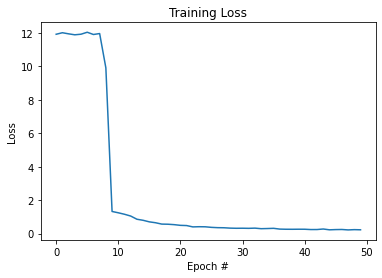

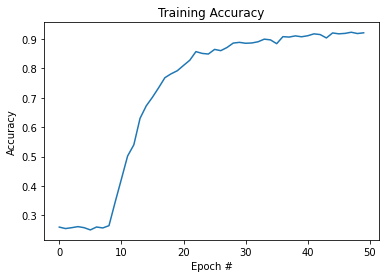

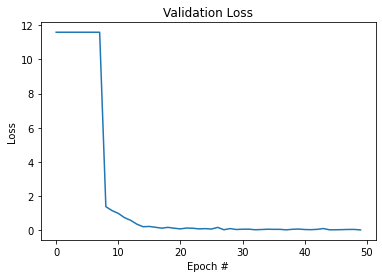

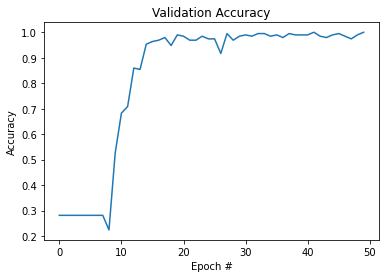

In [12]:
import re
with open(MODEL_HISTORY) as history_file:
    history = history_file.read()

data = {}

data['acc'] = re.findall(' acc: ([0-9]+\.[0-9]+)', history)
data['loss'] = re.findall(' loss: ([0-9]+\.[0-9]+)', history)
data['val_acc'] = re.findall(' val_acc: ([0-9]+\.[0-9]+)', history)
data['val_loss'] = re.findall(' val_loss: ([0-9]+\.[0-9]+)', history)

for key, values in data.items():
    for i, val in enumerate(values):
        values[i] = float(val)

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['loss'])


plt.figure()
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['acc'])


plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['val_loss'])


plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['val_acc'])

In [13]:
model.save("model_flinty_black_white.hdf5")